# Temperature lapsing and data_step
The size discrepancy between MERIT basins and the typical coverage of ERA5 grid cells makes it appropriate to apply a temperature lapse rate. This script loops over existing basin-averaged forcing files and applies a lapse rate to the `airtemp` variable. Lapse arte is determined based on the average elevation difference between the basin shape and the ERA5 grid cell(s) that cover the basin.

In addition, this script adds the `data_step` variable to each forcing file, which SUMMA needs to know the time resolution of the forcing inputs.

#### Environmental Lapse Rate
The temperature lapse rate is assumed to have a constant value of `0.0065` `[K m-1]` (Wallace & Hobbs, 2006, p. 421).

_Wallace, J., and P. Hobbs (2006), Atmospheric Science: An Introductory Survey, 483 pp., Academic Press, Burlington, Mass_

In [24]:
# modules
import os
import numpy as np
import xarray as xr
import pandas as pd
from pathlib import Path
from shutil import copyfile
from datetime import datetime
from utils.read_files import make_default_path, read_from_control
import geopandas as gpd
import xarray as xr


#### Control file handling

In [25]:
# Store the name of the 'active' file in a variable
controlFile = 'control_TuolumneRiver.txt'

#### Find location of intersection file

In [26]:
# Intersected shapefile path. Name is set by EASYMORE as [prefix]_intersected_shapefile.shp
intersect_path = read_from_control(controlFile,'intersect_forcing_path')

# Specify default path if needed
if intersect_path == 'default':
    intersect_path = make_default_path('shapefiles/catchment_intersection/with_forcing', controlFile) # outputs a Path()
else:
    intersect_path = Path(intersect_path) # make sure a user-specified path is a Path()

# Make the file name
domain = read_from_control(controlFile,'domain_name')
intersect_name = domain + '_remapping.nc' # can also be .shp, but using the .csv is easier on memory

#### Find where the EASYMORE-prepared forcing files are

In [27]:
# Forcing files as produced by EASYMORE
forcing_easymore_path = read_from_control(controlFile,'forcing_basin_avg_path')

# Specify default path if needed
if forcing_easymore_path == 'default':
    forcing_easymore_path = make_default_path('forcing/3_basin_averaged_data', controlFile) # outputs a Path()
else:
    forcing_easymore_path = Path(forcing_easymore_path) # make sure a user-specified path is a Path()

# Find the files
_,_,forcing_files = next(os.walk(forcing_easymore_path))

#### Find the time step size of the forcing data

In [28]:
# Value in control file
data_step = read_from_control(controlFile,'forcing_time_step_size')
# Convert to int
data_step = int(data_step)


#### Find where the final forcing needs to go

In [29]:
# Location for SUMMA-ready files
forcing_summa_path = read_from_control(controlFile,'forcing_summa_path')

# Specify default path if needed
if forcing_summa_path == 'default':
    forcing_summa_path = make_default_path('forcing/4_SUMMA_input', controlFile) # outputs a Path()
else:
    forcing_summa_path = Path(forcing_summa_path) # make sure a user-specified path is a Path()

# Make the folder if it doesn't exist
forcing_summa_path.mkdir(parents=True, exist_ok=True)

#### Find the area-weighted lapse value for each basin

In [30]:
# Load the intersection file
topo_data = xr.open_dataset(intersect_path / intersect_name).to_dataframe()

# Find hruId name in user's shapefile
hru_ID_name = read_from_control(controlFile,'catchment_shp_hruid')
gru_ID_name = read_from_control(controlFile,'catchment_shp_gruid')

# Specify the column names
# Note that column names are truncated at 10 characters in the ESRI shapefile, but NOT in the .csv we use here
gru_ID         = 'S_1_' + gru_ID_name # EASYMORE prefix + user's hruId name
hru_ID         = 'S_1_' + hru_ID_name # EASYMORE prefix + user's hruId name
forcing_ID     = 'S_2_ID'             # fixed name assigned by EASYMORE
catchment_elev = 'S_1_elev_mean'      # EASYMORE prefix + name used in catchment+DEM intersection step
forcing_elev   = 'S_2_elev_m'         # EASYMORE prefix + name used in ERA5 shapefile generation
weights        = 'weight'             # EASYMORE feature

# Define the lapse rate
lapse_rate = 0.0065 # [K m-1]

In [31]:
# Calculate weighted lapse values for each HRU 
# Note that these lapse values need to be ADDED to ERA5 temperature data
topo_data['lapse_values'] = topo_data[weights] * lapse_rate * \
    (topo_data[forcing_elev] - topo_data[catchment_elev]) # [K]

In [32]:
# Find the total lapse value per basin; i.e. sum the individual contributions of each HRU+ERA5-grid overlapping part
lapse_values = topo_data.groupby([gru_ID,hru_ID]).lapse_values.sum().reset_index()

In [33]:
# Sort and set hruID as the index variable
lapse_values = lapse_values.sort_values(hru_ID).set_index(hru_ID)
lapse_values

,S_1_GRU_ID,lapse_values
S_1_HRU_ID,,
0,09112500,3.130542
1,09112500,1.273932
2,09112500,0.186682
3,09112500,-0.919388
4,09112500,-0.195047


In [34]:
lapse_values['lapse_values'].values

array([ 3.13054213,  1.27393158,  0.1866818 , -0.91938815, -0.19504735])

In [35]:
# Close the main file
del topo_data # hopefully this saves some RAM but this is apparently not so straightforward in Python.. Can't hurt

#### Check what we're doing

In [36]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [37]:
# Find location of DEM intersection for shapes and elevation
elev_catchment_path = read_from_control(controlFile,'intersect_dem_path')
elev_catchment_name = read_from_control(controlFile,'intersect_dem_name')

# Specify default path if needed
if elev_catchment_path == 'default':
    elev_catchment_path = make_default_path('shapefiles/catchment_intersection/with_dem', controlFile) # outputs a Path()
else:
    elev_catchment_path = Path(elev_catchment_path) # make sure a user-specified path is a Path()

In [38]:
# Find the GRU and HRU identifiers
hm_gruid = read_from_control(controlFile,'catchment_shp_gruid')
hm_hruid = read_from_control(controlFile,'catchment_shp_hruid')

In [39]:
# catchment with DEM
catchment = gpd.read_file(elev_catchment_path/elev_catchment_name)

In [40]:
# Create a shapefile with only GRU boundaries for overlay
hm_grus_only = catchment[[hm_gruid,'geometry']] # keep only the gruId and geometry
hm_grus_only = hm_grus_only.dissolve(by=hm_gruid) # Dissolve HRU delineation

In [41]:
# ensure that HRU_ID is the index
catchment = catchment.set_index(hm_hruid)

In [42]:
# merge with the lapse rate dataframe
catchment['lapse_rate'] = lapse_values['lapse_values']

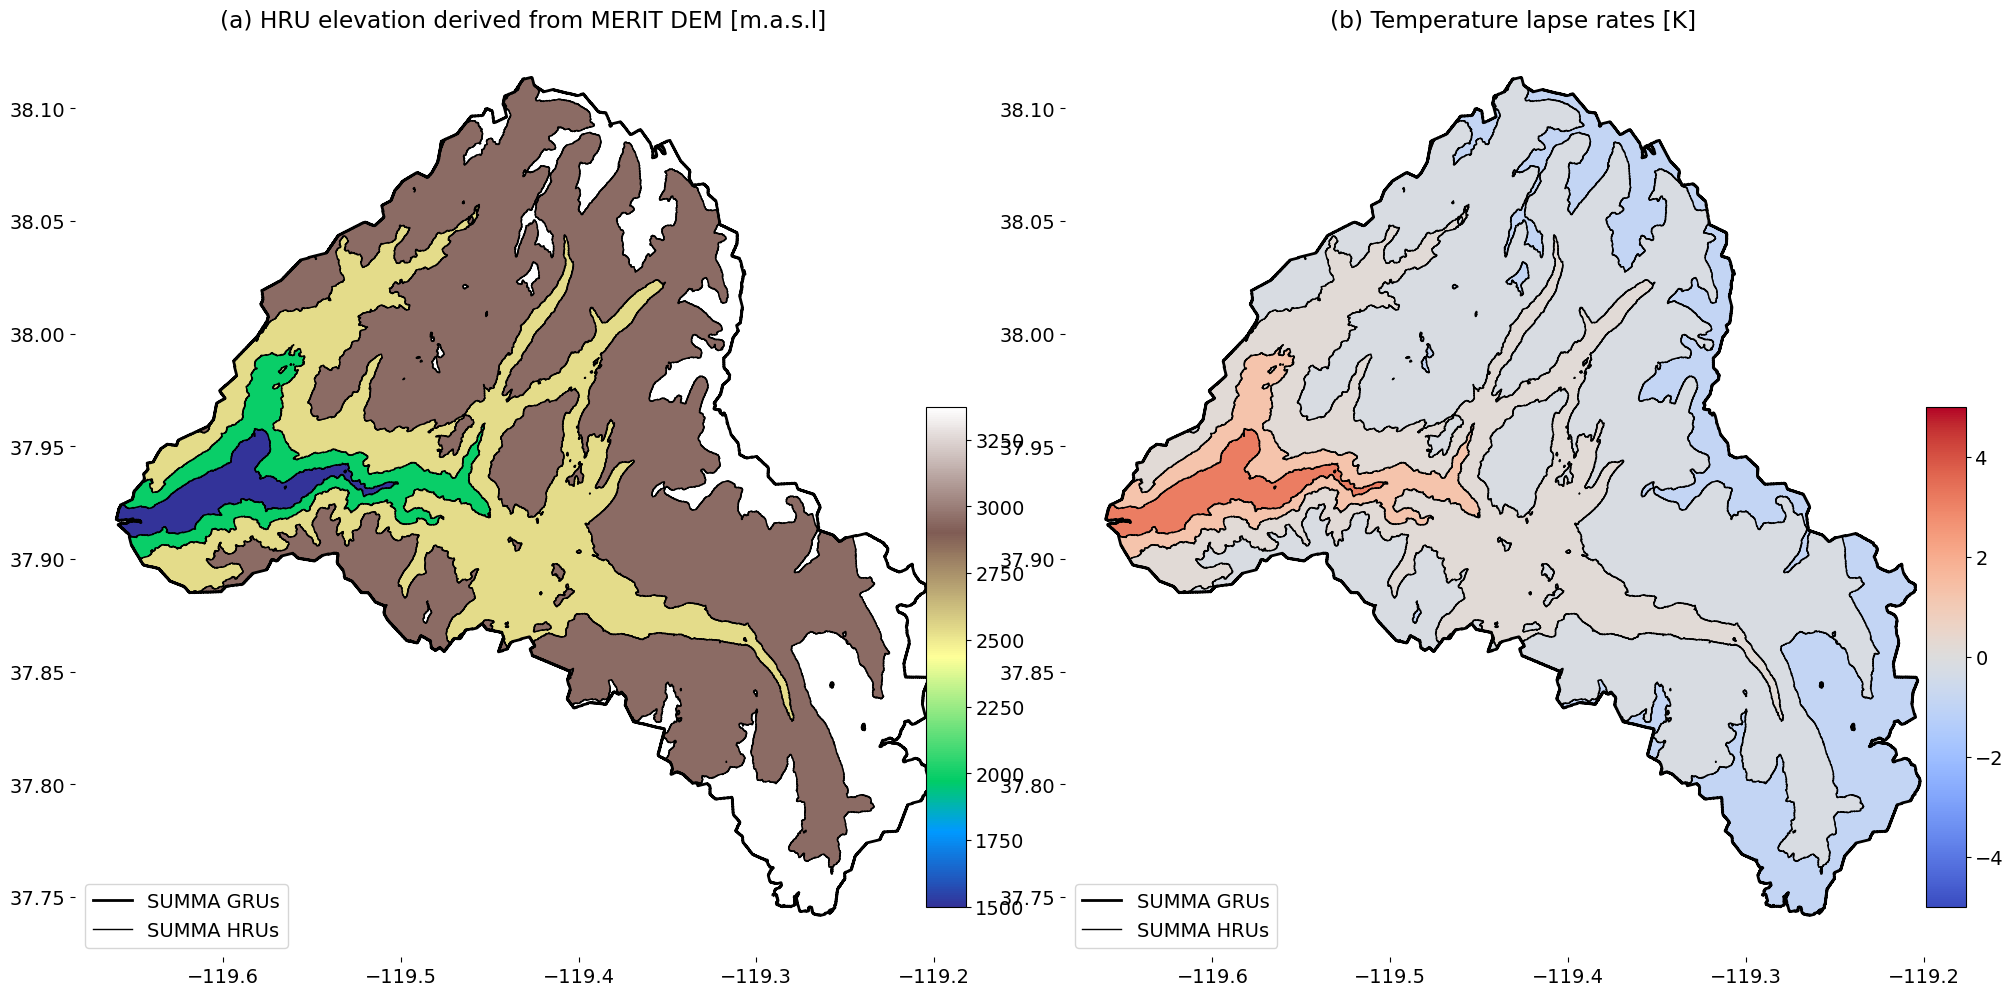

In [43]:
# plot
cmap_elev = 'terrain'
cmap_lapse = 'coolwarm'

# figure
fig, axs = plt.subplots(1,2,figsize=(20,10))
plt.tight_layout()
plt.rcParams.update({'font.size': 14})

# --- elevation
axId = 0

# Data
catchment.plot(ax=axs[axId], column='elev_mean',edgecolor='k', cmap = cmap_elev, legend=False)
hm_grus_only.plot(ax=axs[axId],facecolor='none',edgecolor='k',linewidth=2) 

# Custom colorbar
cax = fig.add_axes([0.46, 0.1, 0.02, 0.5])
vmin,vmax = catchment['elev_mean'].min(),catchment['elev_mean'].max()
sm = plt.cm.ScalarMappable(cmap=cmap_elev, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbr = fig.colorbar(sm, cax=cax)


# Custom legend
lines = [Line2D([0], [0], color='k', lw=2),
         Line2D([0], [0], color='k', lw=1)]
label = ['SUMMA GRUs',
         'SUMMA HRUs']
axs[axId].legend(lines,label,loc='lower left');

# Chart junk
axs[axId].set_title('(a) HRU elevation derived from MERIT DEM [m.a.s.l]');
axs[axId].set_frame_on(False)


# --- lapse rates
axId = 1

# Data
catchment.plot(ax=axs[axId], column='lapse_rate',edgecolor='k', cmap = cmap_lapse, legend=False, vmin=-5, vmax=5)
hm_grus_only.plot(ax=axs[axId],facecolor='none',edgecolor='k',linewidth=2) 

# Custom colorbar
cax = fig.add_axes([0.96, 0.1, 0.02, 0.5])
vmin,vmax = catchment['lapse_rate'].min(),catchment['lapse_rate'].max()
sm = plt.cm.ScalarMappable(cmap=cmap_lapse, norm=plt.Normalize(vmin=-5, vmax=5))
sm._A = []
cbr = fig.colorbar(sm, cax=cax)


# Custom legend
lines = [Line2D([0], [0], color='k', lw=2),
         Line2D([0], [0], color='k', lw=1)]
label = ['SUMMA GRUs',
         'SUMMA HRUs']
axs[axId].legend(lines,label,loc='lower left');

# Chart junk
axs[axId].set_title('(b) Temperature lapse rates [K]');
axs[axId].set_frame_on(False)

#### Loop over forcing files; apply lapse rates and add data_step variable

In [44]:
# Initiate the loop
for file in forcing_files:
    
    # Progress
    print('Starting on ' + file)
    
    # load the data
    with xr.open_dataset(forcing_easymore_path / file) as dat:
    
        # --- Temperature lapse rates
        # Find the lapse rates by matching the HRU order in the forcing file with that in 'lapse_values'
        lapse_values_sorted = lapse_values['lapse_values'].loc[dat['hruId'].values]
    
        # Make a data array of size (nTime,nHru) 
        addThis = xr.DataArray(np.tile(lapse_values_sorted.values, (len(dat['time']),1)), dims=('time','hru')) 
        
        # Get the air temperature variables
        tmp_units = dat['airtemp'].units
    
        # Subtract lapse values from existing temperature data - this creates a new variable without meta-data
        dat['airtemp'] = dat['airtemp'] + addThis
        
        # Add the attributes back in
        dat.airtemp.attrs['long_name'] = "2m air temperature"
        dat.airtemp.attrs['units'] = tmp_units
    
        # --- Time step specification 
        dat['data_step'] = data_step
        dat.data_step.attrs['long_name'] = 'data step length in seconds'
        dat.data_step.attrs['units'] = 's'

        # --- make hru a coordinate
        dat = dat.assign_coords(hru=dat['hru'])

        # make all data variables float64 except data_step
        for var in dat.data_vars:
            if var != 'data_step':
                dat[var] = dat[var].astype('float64')
            else: # convert data_step to timedelta64
                dat[var] = pd.to_timedelta(dat[var].values, unit='ns')
        
        # drop the latitude and longitude variables
        dat = dat.drop_vars(['latitude','longitude'])

        # reorder the data variables
        order = ['data_step','hruId','pptrate','airtemp','windspd','spechum','airpres','LWRadAtm','SWRadAtm']
        dat = dat[order]

        # --- Save to file in new location
        dat.to_netcdf(forcing_summa_path/file) 

Starting on TuolumneRiver_remapped_TuolumneRiver_forcing_2022_2023.nc


In [45]:
dat.close()

#### Check what we're doing

In [46]:
# open old and new file
forcing_old = xr.open_dataset(forcing_easymore_path / file)
forcing_new = xr.open_dataset(forcing_summa_path / file)

/tmp/ipykernel_7256/2144845279.py:3: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  forcing_new = xr.open_dataset(forcing_summa_path / file)


In [47]:
forcing_summa_path / file

PosixPath('/storage/dlhogan/summa_modeling_data/domain_TuolumneRiver/forcing/4_SUMMA_input/TuolumneRiver_remapped_TuolumneRiver_forcing_2022_2023.nc')

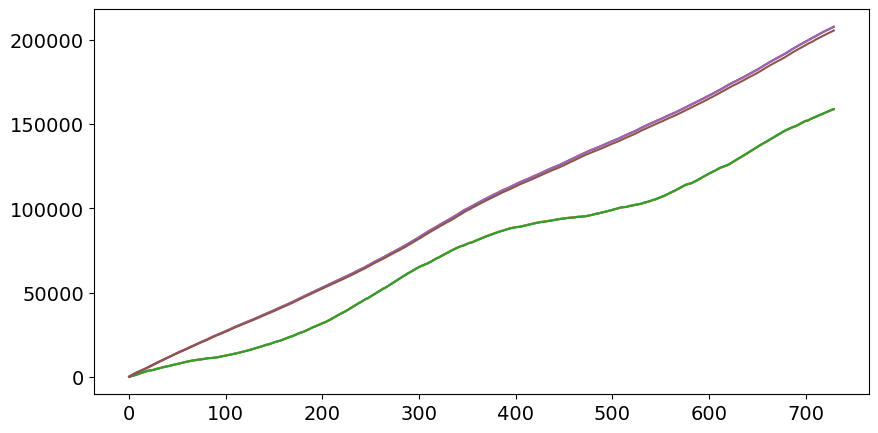

In [48]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(forcing_new.isel(hru=0).SWRadAtm.cumsum())
ax.plot(forcing_new.isel(hru=1).SWRadAtm.cumsum())
ax.plot(forcing_new.isel(hru=2).SWRadAtm.cumsum())

ax.plot(forcing_new.isel(hru=0).LWRadAtm.cumsum())
ax.plot(forcing_new.isel(hru=1).LWRadAtm.cumsum())
ax.plot(forcing_new.isel(hru=2).LWRadAtm.cumsum())

In [49]:
# Prepare dataframes with temperature for a given time
time = 0
old_temp = {'airtemp': forcing_old['airtemp'].isel(time=time).values, 'hruId': forcing_old['hruId']}
new_temp = {'airtemp': forcing_new['airtemp'].isel(time=time).values, 'hruId': forcing_old['hruId']}

In [50]:
# Make dataframes
df_old_temp = pd.DataFrame(old_temp)
df_new_temp = pd.DataFrame(new_temp)

In [51]:
# Set indices
df_old_temp = df_old_temp.set_index('hruId')
df_new_temp = df_new_temp.set_index('hruId')

In [52]:
# Merge with catchment shapefile
catchment['old_T'] = df_old_temp['airtemp']
catchment['new_T'] = df_new_temp['airtemp']

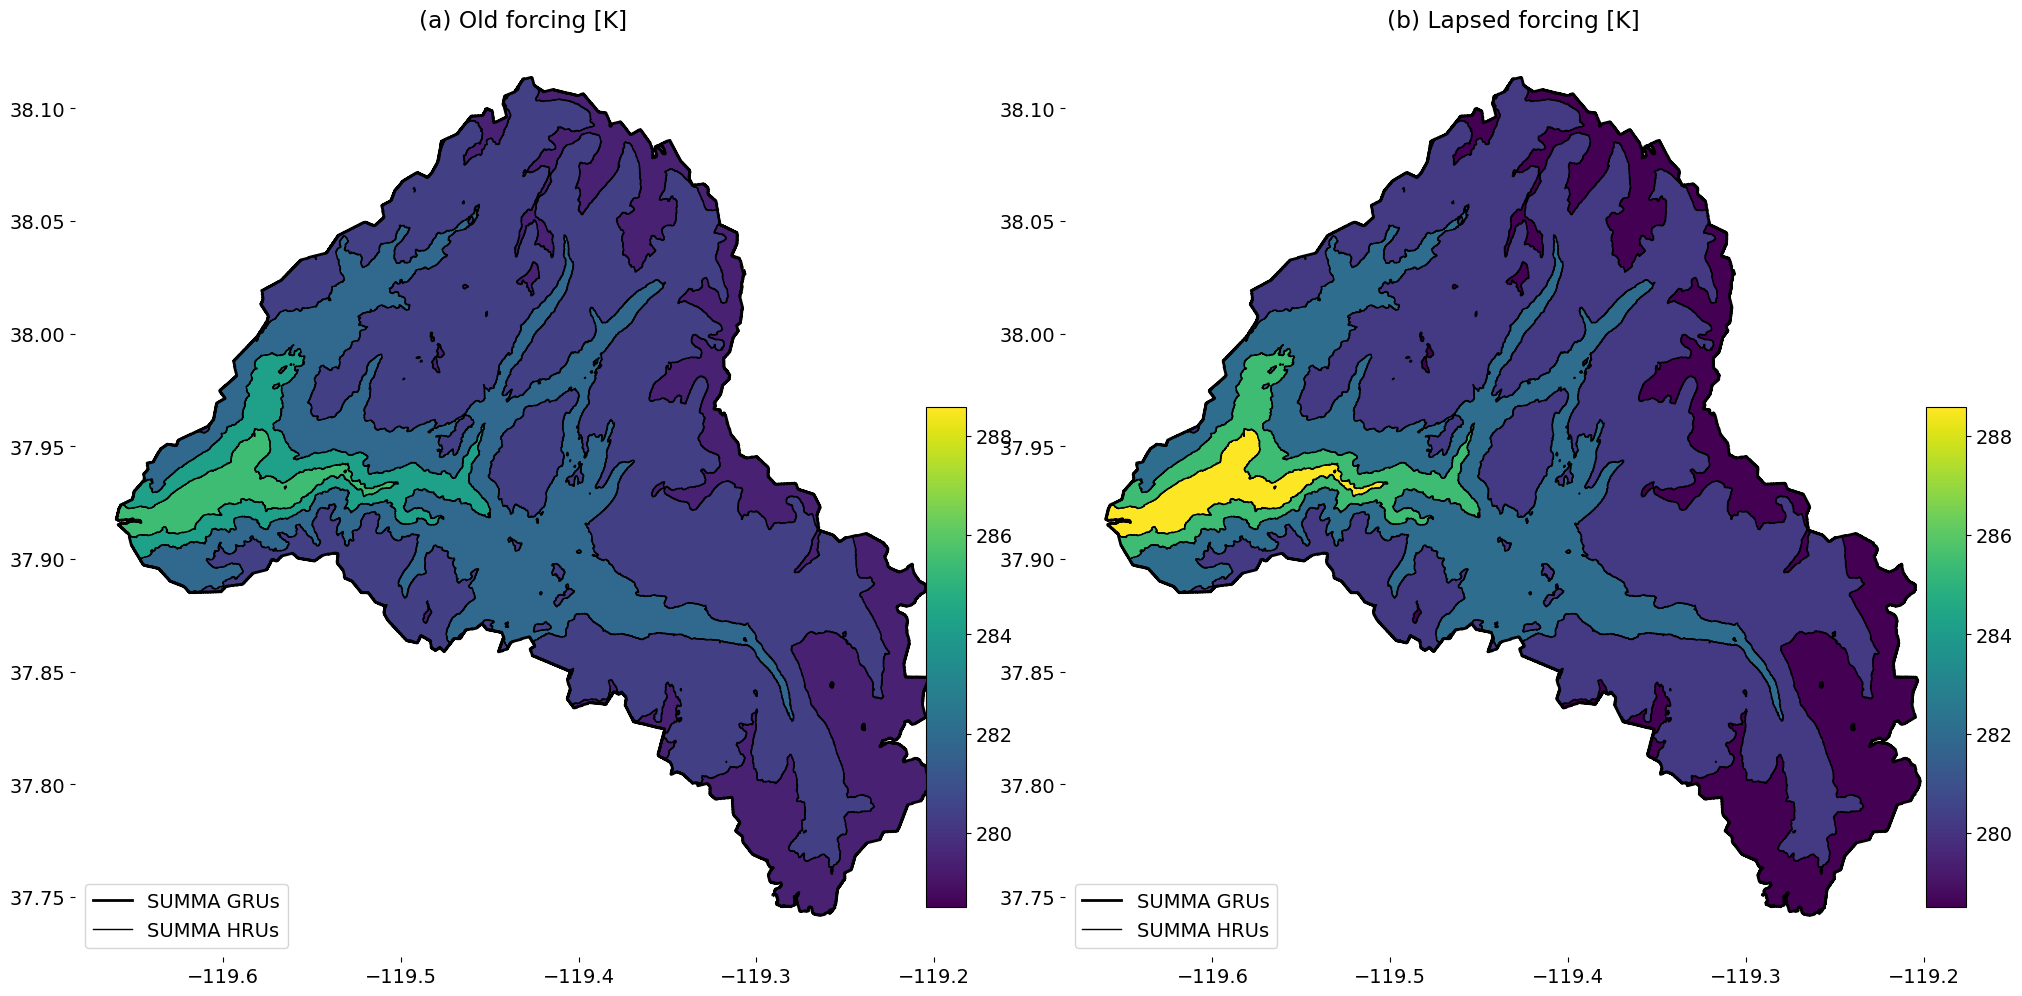

In [53]:
# figure
fig, axs = plt.subplots(1,2,figsize=(20,10))
plt.tight_layout()
plt.rcParams.update({'font.size': 14})

vmin = min(df_new_temp.min().values,df_old_temp.min().values)
vmax = max(df_new_temp.max().values,df_old_temp.max().values)

# --- elevation
axId = 0

# Data
catchment.plot(ax=axs[axId], column='old_T',edgecolor='k', legend=False, vmin=vmin, vmax=vmax)
hm_grus_only.plot(ax=axs[axId],facecolor='none',edgecolor='k',linewidth=2) 

# Custom colorbar
cax = fig.add_axes([0.46, 0.1, 0.02, 0.5])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbr = fig.colorbar(sm, cax=cax)


# Custom legend
lines = [Line2D([0], [0], color='k', lw=2),
         Line2D([0], [0], color='k', lw=1)]
label = ['SUMMA GRUs',
         'SUMMA HRUs']
axs[axId].legend(lines,label,loc='lower left');

# Chart junk
axs[axId].set_title('(a) Old forcing [K]');
axs[axId].set_frame_on(False)


# --- lapse rates
axId = 1

# Data
catchment.plot(ax=axs[axId], column='new_T',edgecolor='k', legend=False, vmin=vmin, vmax=vmax)
hm_grus_only.plot(ax=axs[axId],facecolor='none',edgecolor='k',linewidth=2) 

# Custom colorbar
cax = fig.add_axes([0.96, 0.1, 0.02, 0.5])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbr = fig.colorbar(sm, cax=cax)


# Custom legend
lines = [Line2D([0], [0], color='k', lw=2),
         Line2D([0], [0], color='k', lw=1)]
label = ['SUMMA GRUs',
         'SUMMA HRUs']
axs[axId].legend(lines,label,loc='lower left');

# Chart junk
axs[axId].set_title('(b) Lapsed forcing [K]');
axs[axId].set_frame_on(False)

In [54]:
# close files
forcing_old.close()
forcing_new.close()